# QuTiP Lecture: Pulse-wise two-photon interference of emission from a two-level system

K.A. Fischer, Stanford University

This Jupyter notebook demonstrates how to simulate the two-photon interference between two potentially identical two-level systems, using QuTiP: The Quantum Toolbox in Python. The purpose is to help characterize the quality of a two-level system as a single-photon source and the capability of two such sources to interfere; ideal pulsed single-photon sources have both zero second-order coherence and complete first-order coherence, and the sources must match in spatio-temporal overlap to be indistinguishable. In this notebook, we will assume the spatial modes are comparable so we can focus on temporal effects. This notebook closely follows an example from my simulation paper, <a href="http://dx.doi.org/10.1088/1367-2630/18/11/113053">Dynamical modeling of pulsed two-photon interference</a>, published as New J. Phys. 18 113053 (2016).

For more information about QuTiP see the project web page: http://qutip.org/ 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import interp2d

In [3]:
from qutip import *

## Introduction

The quantum two-level system (TLS) is the simplest possible model for quantum light-matter interaction. In the version we simulate here, the system is driven by a continuous-mode coherent state, whose dipolar interaction with the system is represented by the following Hamiltonain

$$ H =\hbar \omega_0 \sigma^\dagger \sigma + \frac{\hbar\Omega(t)}{2}\left( \sigma\textrm{e}^{-i\omega_dt} + \sigma^\dagger \textrm{e}^{i\omega_dt}\right),$$

where $\omega_0$ is the system's transition frequency, $\sigma$ is the system's atomic lowering operator, $\omega_d$ is the coherent state's center frequency, and $\Omega(t)$ is the coherent state's driving strength.

The time-dependence can be removed to simplify the simulation by a rotating frame transformation, and is particularly simple when the driving field is resonant with the transition frequency ($\omega_d=\omega_0$). Then,

$$ H_r =\frac{\hbar\Omega(t)}{2}\left( \sigma+ \sigma^\dagger \right).$$

### Problem parameters

We will explore emission from the two-level system under two different regimes: under excitation by a short pulse which gives rise to an exponential wavepacket and under excitation by a long pulse which gives rise to a Gaussian wavepacket. (Short and long are relative to the spontaneous emission time of the atomic transition.) In both cases, the driving strengths are chosen such that the expected number of photodetections is unity, i.e.

$$ \gamma\int \langle \sigma^\dagger (t) \sigma(t)\rangle=1 .$$

As a result, we can compare the statistics of the emission directly and the normalizations become trivial.

Note, we use units where $\hbar=1$.

In [4]:
# shared parameters
gamma = 1                        # decay rate
tlist = np.linspace(0, 13, 300)
taulist = tlist

# parameters for TLS with exponential shape wavepacket (short pulse)
tp_e = 0.060                     # Gaussian pulse parameter
Om_e = 19.40                     # driving strength
t_offset_e = 0.405
pulse_shape_e = Om_e/2 * np.exp(-(tlist - t_offset_e) ** 2 /
                                (2 * tp_e ** 2))

# parameters for TLS with Gaussian shape wavepacket (long pulse)
tp_G = 2.000                     # Gaussian pulse parameter
Om_G = 0.702                     # driving strength
t_offset_G = 5
pulse_shape_G = Om_G/2 * np.exp(-(tlist - t_offset_G) ** 2 /
                                (2 * tp_G ** 2))

### Setup the operators, Hamiltonian, and initial state

In [5]:
# initial state
psi0 = fock(2, 0)              # ground state

# operators
sm = destroy(2)                # atomic lowering operator
n = [sm.dag()*sm]              # number operator

# Hamiltonian
H_I = sm + sm.dag()
H_e = [[H_I, pulse_shape_e]]
H_G = [[H_I, pulse_shape_G]]

# collapse operator that describes dissipation
c_ops = [np.sqrt(gamma) * sm]  # represents spontaneous emission

## Calculate the emission flux

We evolve the system with the Lindblad master equation solver, and we request that the expectation values of the number operator $\hat{n}=\sigma^{\dagger} \sigma$ are returned by the solver. If the probability of two photodetections were negligible over the course of the pulse, then $\langle \hat{n}(t) \rangle$ would be the probability density of a detection occuring on an ideal detector at time $t$.

In [6]:
n_e = mesolve(H_e, psi0, tlist, c_ops, n).expect[0]
n_G = mesolve(H_G, psi0, tlist, c_ops, n).expect[0]

### Visualize the emission flux

We plot the emission flux from two different three-level systems. The system labelled 'exponential wavepacket' was excited with a short pulse, while the system labelled 'Gaussian wavepacket' was excited with a long pulse.

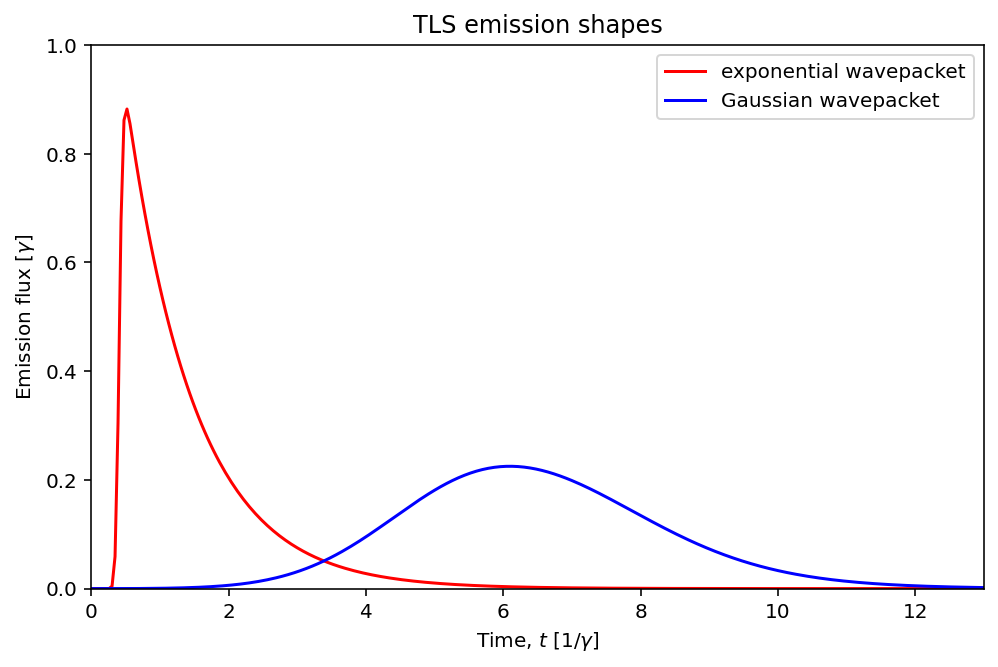

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(tlist, n_e, 'r', label="exponential wavepacket")
ax.plot(tlist, n_G, 'b', label="Gaussian wavepacket")
ax.legend()
ax.set_xlim(0, 13)
ax.set_ylim(0, 1)
ax.set_xlabel('Time, $t$ [$1/\gamma$]')
ax.set_ylabel('Emission flux [$\gamma$]')
ax.set_title('TLS emission shapes');

## Calculate the correlators involved in two-photon interference

When two indistinguishable photons impinge on two ports of a beamsplitter at the same time, they exit together. Such a configuration, with intensity detectors at each output, is known as a Hong-Ou-Mandel interferometer. This interferometer measures two-photon interference in the pulse-wise cross-correlation of the detection records of its photon counters.

If each of the two interfering wavepackets has unity average photon number, then the formula for this normalized cross-correlation is

$$ g^{(2)}_\textrm{HOM}[0] = \frac{1}{4}\left(g^{(2)}_{aa}[0] + g^{(2)}_{bb}[0])\right) + \frac{1}{2}\left(1-\textrm{Re}\iint \mathop{\textrm{d} t} \mathop{\textrm{d} t'}  \left[G^{(1)}_a(t,t')\right]^*G^{(1)}_b(t,t')\right) ,$$

where $a$ and $b$ label the wavepackets, $g^{(2)}_{aa(bb)}[0]$ are the sources' measured degrees of second-order coherence, and $G^{(1)}_{a(b)}(t,t')$ are the sources' first-order optical coherences. Specifically

$$ G^{(1)}_{a(b)}(t,t') = \gamma \langle \sigma_{a(b)}^\dagger(t) \sigma_{a(b)}(t') \rangle,$$

which we will calculate in this notebook with the master equation solver and quantum regression theorem. Importantly, if $g^{(2)}_\textrm{HOM}[0]=0$ then the photons always exit an output port of the beamsplitter together. Note: for the sources in question $g^{(2)}_{aa(bb)}[0]$ was calculated in the QuTiP example, <i>Pulse-wise second-order optical coherences of emission from a two-level system</i>.

In [8]:
# specify relevant operators to calculate the correlation
# <A(t+tau)B(t)>
a_op = sm.dag()
b_op = sm

# calculate two-time correlations
G1_t_tau_e = correlation_2op_2t(H_e, psi0, tlist, taulist, c_ops,
                                a_op, b_op, reverse=True)
G1_t_tau_e_r = correlation_2op_2t(H_e, psi0, tlist, taulist, c_ops,
                                  a_op, b_op)
G1_t_tau_G = correlation_2op_2t(H_G, psi0, tlist, taulist, c_ops,
                                a_op, b_op, reverse=True)
G1_t_tau_G_r = correlation_2op_2t(H_G, psi0, tlist, taulist, c_ops,
                                  a_op, b_op)

# g^(2)[0] values calculated for the sources in question in the
# notebook 'Pulse-wise second-order optical coherences of emission
# from a two-level system'
g20_e = 0.03
g20_G = 0.44

### Interpolate these functions, in preparation for time delays

In [9]:
t_delay_list = np.linspace(-5, 0, 50)
TAULIST, TLIST = np.meshgrid(taulist, tlist)

c1_e = interp2d(taulist, tlist, np.real(G1_t_tau_e))
c1_e_f = lambda tau, t: c1_e(tau, t)

c2_e = interp2d(taulist, tlist, np.real(G1_t_tau_e_r))
c2_e_f = lambda tau, t: c2_e(tau, t)

c1_G = interp2d(taulist, tlist, np.real(G1_t_tau_G))
c1_G_f = lambda tau, t: c1_G(tau, t)

c2_G = interp2d(taulist, tlist, np.real(G1_t_tau_G_r))
c2_G_f = lambda tau, t: c2_G(tau, t)

## Calculate measured degrees of HOM cross-correlation

In [10]:
# two delayed exponential wavepackets interfere

def g2HOM_exponential(t_delay):
    corr_e = np.array(
        [[c1_e_f(tau, t)[0] * c2_e_f(tau, t - t_delay)[0] 
          for tau in taulist]
         for t in tlist]
    )
    return g20_e/2 + 1/2*abs(1 -
        2 * np.trapz(np.trapz(corr_e, TLIST, axis=0), taulist)
    )

g2HOM_e = parallel_map(g2HOM_exponential, t_delay_list)

In [11]:
# two delayed Gaussian wavepackets interfere

def g2HOM_Gaussian(t_delay):
    corr_G = np.array(
        [[c1_G_f(tau, t)[0] * c2_G_f(tau, t - t_delay)[0] 
          for tau in taulist]
         for t in tlist]
    )
    return g20_G/2 + 1/2*abs(1 -
        2 * np.trapz(np.trapz(corr_G, TLIST, axis=0), taulist)
    )
    
g2HOM_G = parallel_map(g2HOM_Gaussian, t_delay_list)

In [12]:
# a delayed Gaussian wavepacket interferes with an exponential
# wavepacket

def g2HOM_Gaussian_exp(t_delay):
    corr_Ge = np.array(
        [[c1_e_f(tau, t)[0] * c2_G_f(tau, t - t_delay)[0] 
          for tau in taulist]
         for t in tlist]
    )
    return (g20_e + g20_G)/4 + 1/2*abs(1 -
        2 * np.trapz(np.trapz(corr_Ge, TLIST, axis=0), taulist)
    )
    
g2HOM_Ge = parallel_map(g2HOM_Gaussian_exp, t_delay_list + 5.45)

### Visualize the two-photon interference visibilities

Here, the exponential wavepackets show good HOM interference visibility at zero delay, dipping down to almost zero (red). Meanwhile, in the case of the Gaussian wavepackets, the significant probability of re-excitation (due to $g^{(2)}_{aa}[0]=0.44$) partially destroys the HOM interference (blue); the HOM dip at zero delay still is below the nonclassical threshold (dashed line). However, if the Gaussian and exponential wavepackets, each generated by two-level systems, are interfered with one-another then the HOM interference is not below the nonclassical threshold (purple). This is a result of the re-excitation action that scrambles the phase of the first-order coherence.

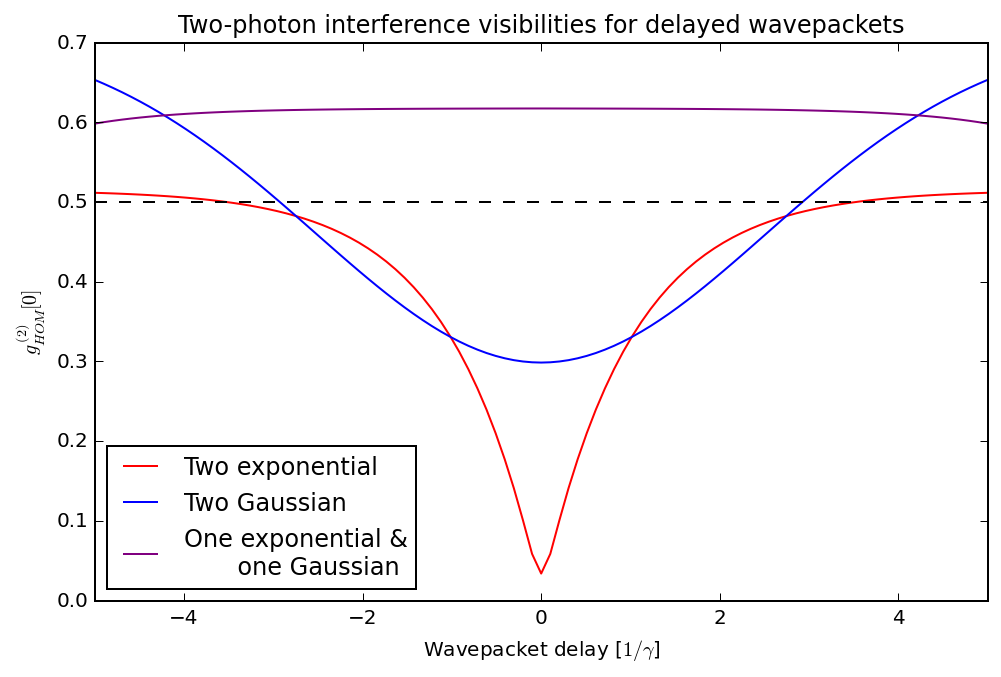

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.concatenate([t_delay_list, -t_delay_list[-2::-1]]),
         np.concatenate([g2HOM_e, g2HOM_e[-2::-1]]), 'r',
        label="Two exponential")
ax.plot(np.concatenate([t_delay_list, -t_delay_list[-2::-1]]),
         np.concatenate([g2HOM_G, g2HOM_G[-2::-1]]), 'b',
        label="Two Gaussian")
ax.plot(np.concatenate([t_delay_list, -t_delay_list[-2::-1]]),
         np.concatenate([g2HOM_Ge, g2HOM_Ge[-2::-1]]), 'purple',
        label="One exponential &\n       one Gaussian")
ax.legend(loc=3)
ax.set_xlim(-5, 5)
ax.axhline(y=0.5, color='k', linestyle='dashed')
ax.set_xlabel('Wavepacket delay [$1/\gamma$]')
ax.set_ylabel('$g^{(2)}_{HOM}[0]$')
ax.set_title('Two-photon interference visibilities for '+
             'delayed wavepackets');

## Versions

In [14]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.3.0.dev0+0f58c6f
Numpy,1.9.2
SciPy,0.18.1
matplotlib,1.4.3
Cython,0.24.1
Number of CPUs,8
BLAS Info,INTEL MKL
IPython,4.2.0
Python,"3.4.3 (default, Nov 17 2016, 01:08:31) [GCC 4.8.4]"
OS,posix [linux]
